In [12]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from utils.ephys_functions import cross_corr_train, auto_corr_train, load_drift, load_auto_corr, load_cross_corr
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.gridspec as gs
%matplotlib inline


In [2]:
def cross_auto_corr(session, data_type):
    bin_long = 0.05
    win_long = 2
    bin_short = 0.002
    win_short = 0.08
    session_dir = session_dirs(session)
    unit_tbl = get_unit_tbl(session, data_type) 
    if unit_tbl['LC_range_top'].unique()[0] is None:
        print(f'LC range not inferred, probably no opto units in {session}. Exiting.')
        return None
    session_tbl = get_session_tbl(session)
    
    session_qm_file = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
    with open(session_qm_file, 'r') as f:
        session_qm = json.load(f)
    rec_start = session_qm['ephys_cut'][0]
    rec_end = session_qm['ephys_cut'][1]

    opto_file = os.path.join(session_dir['opto_dir_curated'], 
                                f'{session}_opto_session.csv')
    opto_tbl = pd.read_csv(opto_file)
    opto_times = opto_tbl['time'].values

    if len(opto_tbl['pre_post'].unique()) > 1:
        rec_start = opto_tbl[opto_tbl['pre_post'] == 'pre']['time'].max()
        rec_end = opto_tbl[opto_tbl['pre_post'] == 'post']['time'].min()
    elif len(opto_tbl['pre_post'].unique()) == 1:
        rec_end = opto_tbl['time'].min()

    filter = (
        (unit_tbl['decoder_label'] != 'artifact') &
        (unit_tbl['decoder_label'] != 'noise') &
        (unit_tbl['isi_violations_ratio'] < 0.5) &
        (unit_tbl['y_loc'] >= unit_tbl['LC_range_bottom'].unique()[0] - 0.1) &
        (unit_tbl['y_loc'] <= unit_tbl['LC_range_top'].unique()[0] + 0.1)
    )

    unit_ids_focus = unit_tbl[filter]['unit_id'].to_list()
    print(f'Number of units in LC range: {len(unit_ids_focus)}')

    cross_corr_df = pd.DataFrame(columns=['unit_1', 'unit_2', 'cross_corr_long', 'cross_corr_short', 'start', 'end', 'long_lags', 'short_lags'])
    auto_corr_df = pd.DataFrame(columns=['unit', 'auto_corr_long', 'auto_corr_short', 'start', 'end', 'long_lags', 'short_lags'])
    for unit_ind_1, unit_1 in enumerate(unit_ids_focus):
        print(f'Processing unit {unit_1}')
        spike_times_1 = unit_tbl[unit_tbl['unit_id'] == unit_1]['spike_times'].values[0]
        drift_1 = load_drift(session, unit_1, data_type)
        start_unit_1 = rec_start
        end_unit_1 = rec_end
        if drift_1 is not None:
            if drift_1['ephys_cut'][0] is not None:
                start_unit_1 = max(start_unit_1, drift_1['ephys_cut'][0])
            if drift_1['ephys_cut'][1] is not None:
                end_unit_1 = min(end_unit_1, drift_1['ephys_cut'][1])
        auto_corr_long, long_lags = auto_corr_train(spike_times_1, bin_long, win_long, start_unit_1, end_unit_1)
        auto_corr_short, short_lags = auto_corr_train(spike_times_1, bin_short, win_short, start_unit_1, end_unit_1)
        dist_out_auto = {'unit': unit_1,
                    'auto_corr_long': auto_corr_long,
                    'auto_corr_short': auto_corr_short,
                    'long_lags': long_lags,
                    'short_lags': short_lags,
                    'start': start_unit_1,
                    'end': end_unit_1}
        auto_corr_df = pd.concat([auto_corr_df, pd.DataFrame([dist_out_auto])], ignore_index=True)
        for unit_ind_2, unit_2 in enumerate(unit_ids_focus):
            cross_corr_long = None
            cross_corr_short = None
            if unit_ind_1 < unit_ind_2:
                print(f'Processing units {unit_1} and {unit_2}')
                spike_times_2 = unit_tbl[unit_tbl['unit_id'] == unit_2]['spike_times'].values[0]
                drift_2 = load_drift(session, unit_2, data_type)
                start = start_unit_1
                end = end_unit_1
                if drift_2 is not None:
                    if drift_2['ephys_cut'][0] is not None:
                        start = max(start, drift_2['ephys_cut'][0])
                    if drift_2['ephys_cut'][1] is not None:
                        end = min(end, drift_2['ephys_cut'][1])
                
                if start >= end:
                    print(f'Skipping units {unit_1} and {unit_2} due to incompatible drift cuts')
                    continue
                cross_corr_long, lags_long = cross_corr_train(spike_times_1, spike_times_2, bin_long, win_long, start, end)
                cross_corr_short, lags_short = cross_corr_train(spike_times_1, spike_times_2, bin_short, win_short, start, end)

                dist_out = {'unit_1': unit_1,
                            'unit_2': unit_2,
                            'cross_corr_long': cross_corr_long,
                            'long_lags': lags_long,
                            'cross_corr_short': cross_corr_short,
                            'short_lags': lags_short,
                            'start': start,
                            'end': end}
                # Append the result to the cross_corr_df dataframe
                if cross_corr_long is not None or cross_corr_short is not None:
                    cross_corr_df = pd.concat([cross_corr_df, pd.DataFrame([dist_out])], ignore_index=True)
    # Save the results to pickle files
    cross_corr_file = os.path.join(session_dir[f'ephys_processed_dir_{data_type}'], f'{session}_{data_type}_cross_corr.pkl')
    auto_corr_file = os.path.join(session_dir[f'ephys_processed_dir_{data_type}'], f'{session}_{data_type}_auto_corr.pkl')
    with open(cross_corr_file, 'wb') as f:
        pickle.dump(cross_corr_df, f)
    with open(auto_corr_file, 'wb') as f:
        pickle.dump(auto_corr_df, f)

In [3]:
cross_auto_corr('ecephys_713854_2024-03-08_15-43-01', 'curated')

Number of units in LC range: 16
Processing unit 3


/tmp/ipykernel_9680/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auto_corr_df = pd.concat([auto_corr_df, pd.DataFrame([dist_out_auto])], ignore_index=True)


Processing units 3 and 4


/tmp/ipykernel_9680/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cross_corr_df = pd.concat([cross_corr_df, pd.DataFrame([dist_out])], ignore_index=True)


Processing units 3 and 5
Processing units 3 and 7
Processing units 3 and 10
Processing units 3 and 13
Processing units 3 and 14
Processing units 3 and 18
Processing units 3 and 20
Processing units 3 and 21
Processing units 3 and 24
Processing units 3 and 126
Processing units 3 and 165
Processing units 3 and 166
Processing units 3 and 172
Processing units 3 and 173
Processing unit 4
Processing units 4 and 5
Processing units 4 and 7
Processing units 4 and 10
Processing units 4 and 13
Processing units 4 and 14
Processing units 4 and 18
Processing units 4 and 20
Processing units 4 and 21
Processing units 4 and 24
Processing units 4 and 126
Processing units 4 and 165
Processing units 4 and 166
Processing units 4 and 172
Processing units 4 and 173
Processing unit 5
Processing units 5 and 7
Processing units 5 and 10
Processing units 5 and 13
Processing units 5 and 14
Processing units 5 and 18
Processing units 5 and 20
Processing units 5 and 21


/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Processing units 5 and 24
Processing units 5 and 126
Processing units 5 and 165
Processing units 5 and 166
Processing units 5 and 172
Processing units 5 and 173
Processing unit 7
Processing units 7 and 10
Processing units 7 and 13
Processing units 7 and 14
Processing units 7 and 18
Processing units 7 and 20
Processing units 7 and 21
Processing units 7 and 24
Processing units 7 and 126
Processing units 7 and 165
Processing units 7 and 166
Processing units 7 and 172
Processing units 7 and 173
Processing unit 10
Processing units 10 and 13
Processing units 10 and 14
Processing units 10 and 18
Processing units 10 and 20
Processing units 10 and 21
Processing units 10 and 24
Processing units 10 and 126
Processing units 10 and 165
Processing units 10 and 166
Processing units 10 and 172
Processing units 10 and 173
Processing unit 13
Processing units 13 and 14
Processing units 13 and 18
Processing units 13 and 20
Processing units 13 and 21
Processing units 13 and 24
Processing units 13 and 126
P

In [13]:
session = 'ecephys_713854_2024-03-08_15-43-01'
unit_id = 7
data_type = 'curated'
auto_corr = load_auto_corr(session, data_type)
cross_corr = load_cross_corr(session, data_type)

In [19]:
unit_tbl['opto_pass']

0       True
1      False
2       True
3       True
4       True
       ...  
144    False
145    False
146    False
147     True
148     True
Name: opto_pass, Length: 149, dtype: bool

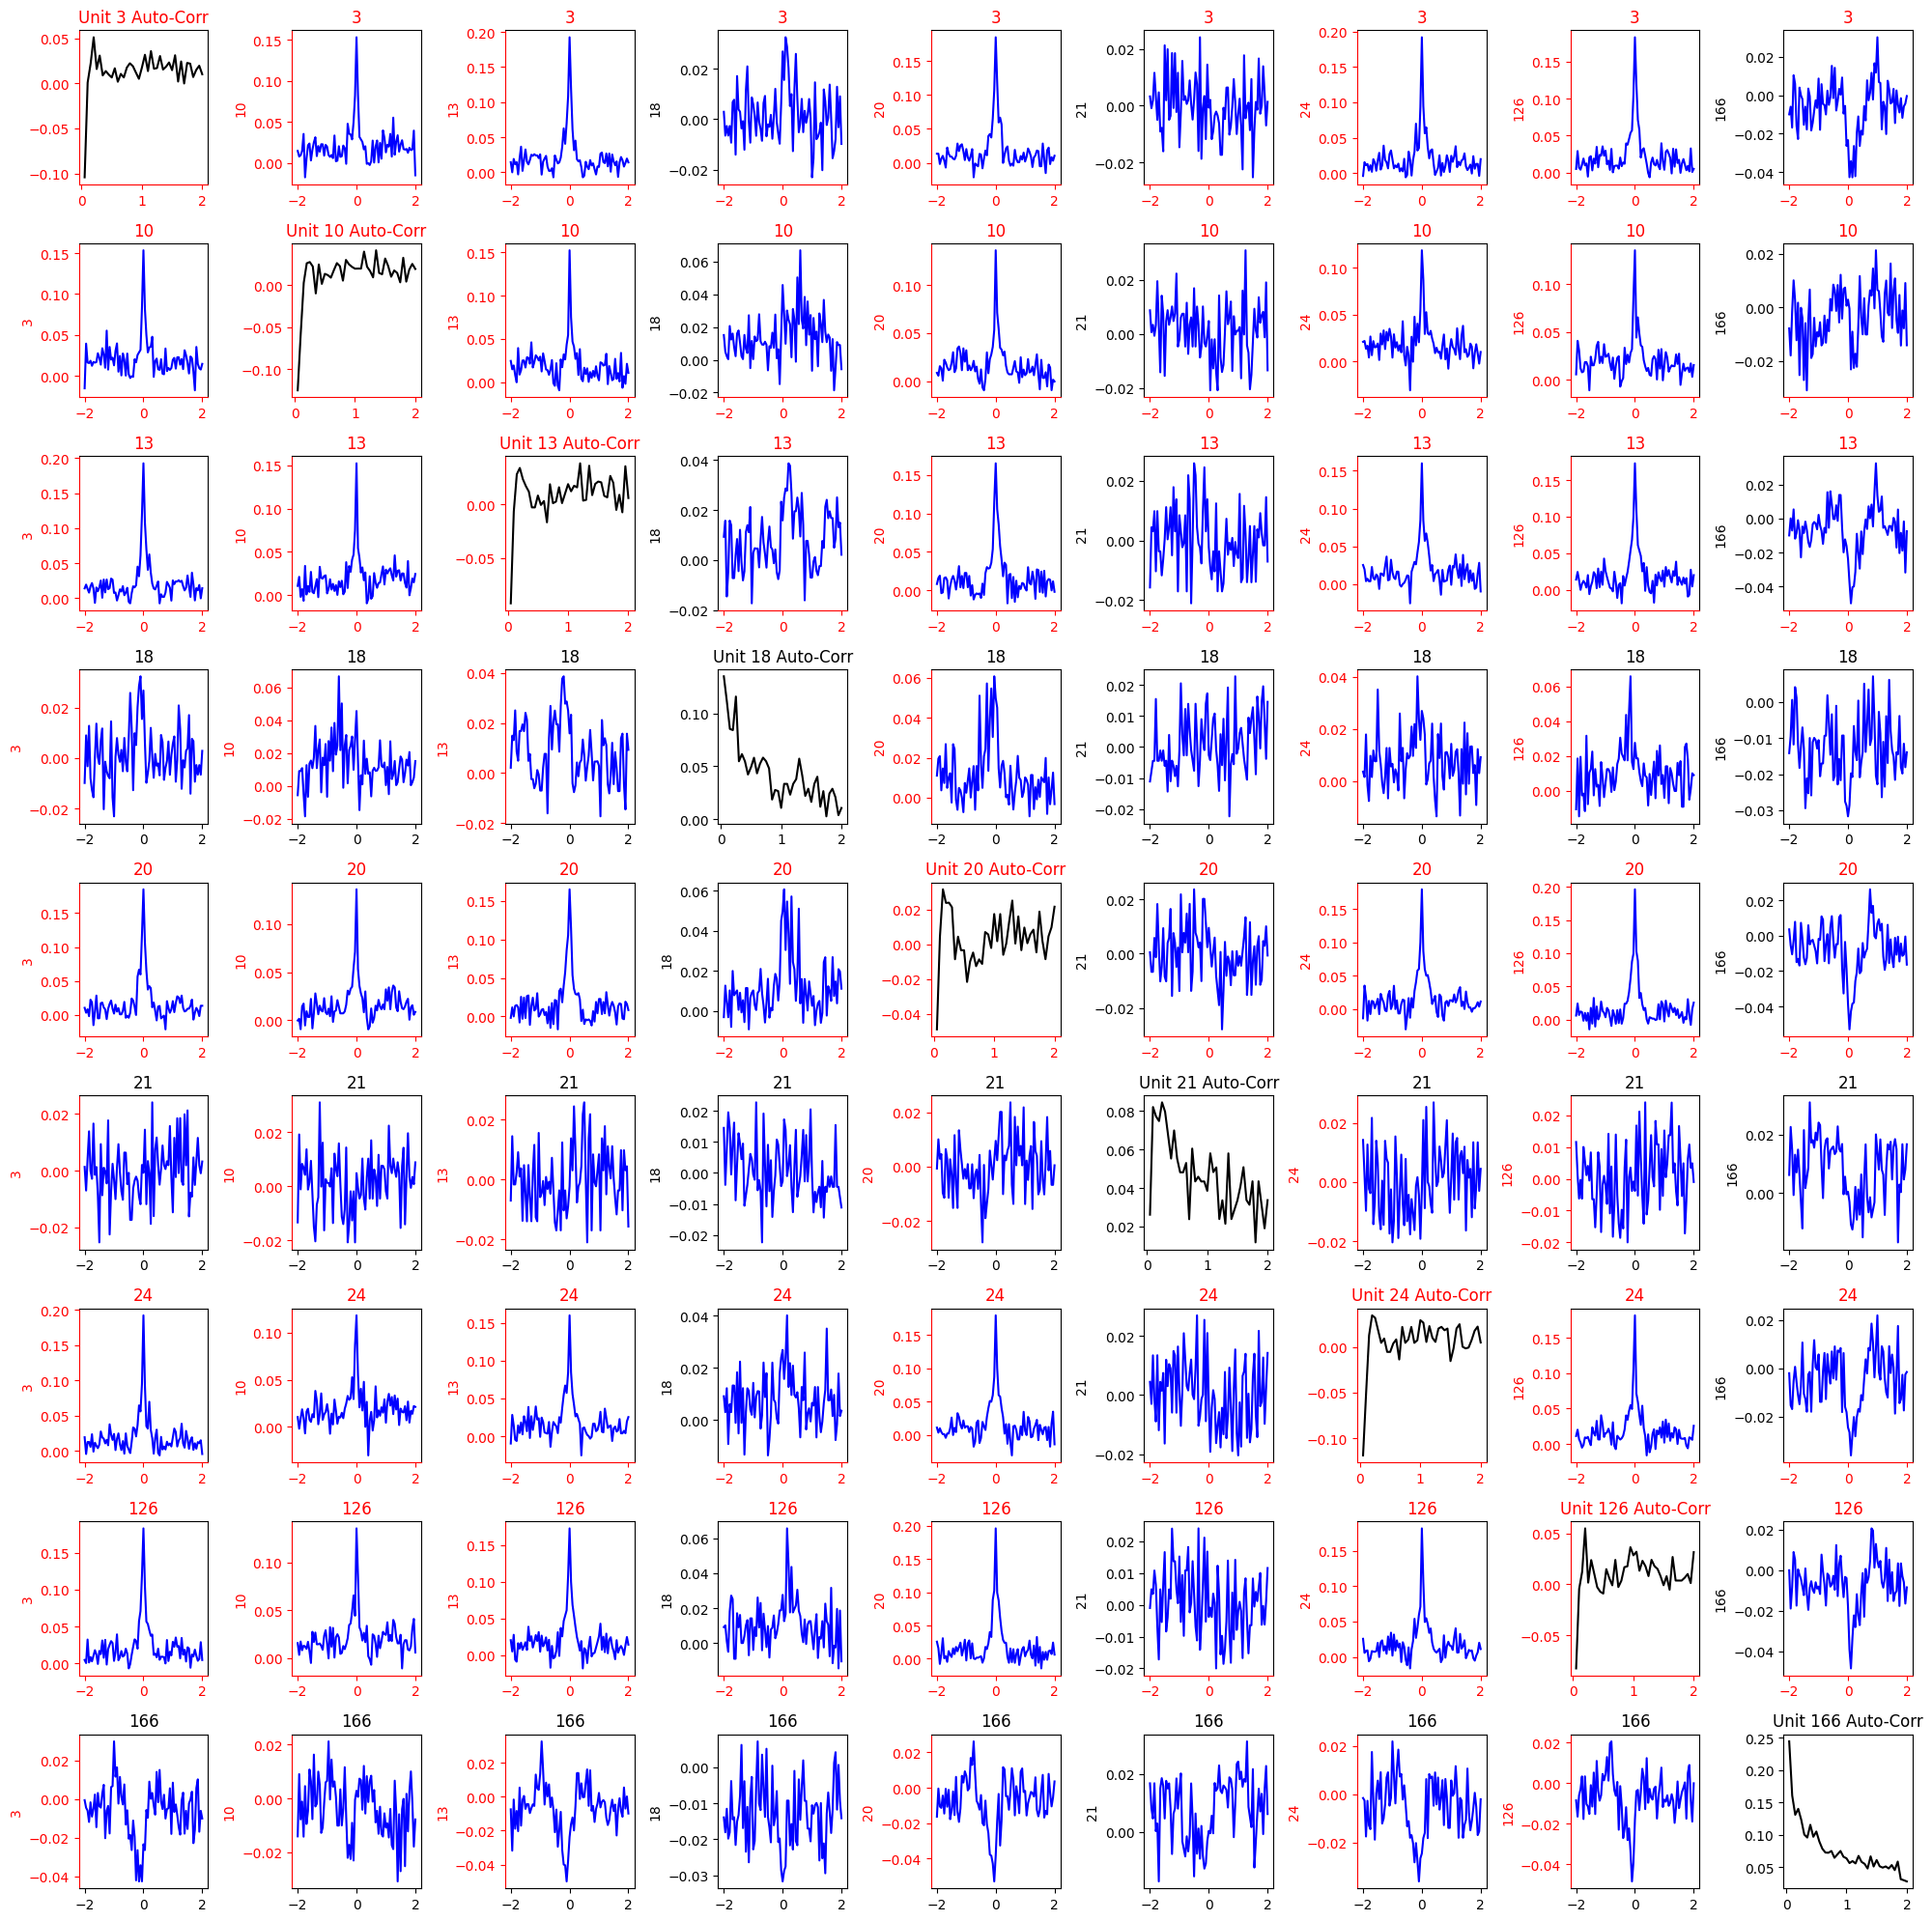

In [26]:
def plot_cross_auto_corr(session, data_type):
    unit_tbl = get_unit_tbl(session, data_type)
    filter = (
        (unit_tbl['decoder_label'] != 'artifact') &
        (unit_tbl['decoder_label'] != 'noise') &
        (unit_tbl['isi_violations_ratio'] < 0.1) &
        (unit_tbl['y_loc'] >= unit_tbl['LC_range_bottom'].unique()[0] - 0.1) &
        (unit_tbl['y_loc'] <= unit_tbl['LC_range_top'].unique()[0] + 0.1)
    )
    unit_ids_focus = unit_tbl[filter]['unit_id'].to_list()
    auto_corr = load_auto_corr(session, data_type)
    cross_corr = load_cross_corr(session, data_type)
    if auto_corr is None or cross_corr is None:
        print(f'No auto/cross correlation data found for session {session} and data type {data_type}. Exiting.')
        return None
    gs_crosscorr = gs.GridSpec(len(unit_ids_focus), len(unit_ids_focus))
    fig = plt.figure(figsize=(20, 20))
    for unit_1_ind, unit_1 in enumerate(unit_ids_focus):
        for unit_2_ind, unit_2 in enumerate(unit_ids_focus):
            ax = fig.add_subplot(gs_crosscorr[unit_1_ind, unit_2_ind])
            if unit_1 == unit_2:
                unit_auto_corr = auto_corr.load_unit(unit_1)
                ax.plot(unit_auto_corr['long_lags'][1:], unit_auto_corr['auto_corr_long'][1:], label='Long', color='k')
                # ax.plot(unit_auto_corr['short_lags'], unit_auto_corr['auto_corr_short'], label='Short', color='orange')
                ax.set_title(f'Unit {unit_1} Auto-Corr')
                # ax.legend()
            else:
                cross_corr_units = cross_corr.load_units(unit_1, unit_2)
                if cross_corr_units is not None:
                    ax.plot(cross_corr_units['long_lags'], cross_corr_units['cross_corr_long'], label='Long', color='blue')
                    # ax.plot(cross_corr['short_lags'], cross_corr['cross_corr_short'], label='Short', color='orange')
                    ax.set_title(f'{unit_1}')
                    ax.set_ylabel(f'{unit_2}')
                    # ax.legend()
                else:
                    ax.set_visible(False)
            if unit_tbl[unit_tbl['unit_id'] == unit_1]['opto_pass'].values[0]:
                ax.spines['bottom'].set_color('red')        # x-axis line
                ax.tick_params(axis='x', colors='red')      # tick labels and ticks
                ax.xaxis.label.set_color('red')
                ax.set_title(ax.get_title(), color='red')
            if unit_tbl[unit_tbl['unit_id'] == unit_2]['opto_pass'].values[0]:
                ax.spines['left'].set_color('red')         # y-axis line
                ax.tick_params(axis='y', colors='red')
                ax.yaxis.label.set_color('red')

    plt.tight_layout()
    fig.savefig(fname=os.path.join(session_dirs(session)[f'ephys_processed_dir_{data_type}'], f'{session}_{data_type}_cross_auto_corr.png'))
plot_cross_auto_corr(session, data_type)

In [5]:
cross_corr = load_cross_corr(session, data_type)
unit_1 = 7
unit_2 = 10
unit_cross_corr = cross_corr.load_units(unit_1, unit_2)
unit_cross_corr_test = cross_corr.load_units(unit_2, unit_1)

In [6]:
unit_cross_corr

{'unit_1': 7,
 'unit_2': 10,
 'cross_corr_long': array([ 0.00910129,  0.01960386,  0.02411355,  0.02776556,  0.01430136,
         0.02779583,  0.0172217 ,  0.02322597,  0.00964836,  0.00816699,
         0.01780562,  0.02156179,  0.02531784,  0.0141107 ,  0.01637047,
         0.03434088,  0.00881652,  0.02154645,  0.00585574,  0.00811486,
         0.01186967,  0.01626702,  0.0088057 ,  0.0118117 ,  0.02453687,
         0.02529965,  0.01185774,  0.02522249,  0.03271159,  0.02076844,
         0.01405728,  0.02590827,  0.02144051,  0.0259385 ,  0.02659302,
         0.03706497,  0.04156134,  0.03784173,  0.03923951,  0.04149444,
         0.0766026 ,  0.05579646,  0.01769082,  0.02601348,  0.02002151,
         0.00966427, -0.00368908, -0.00669484,  0.01422134,  0.00384168,
         0.00083511,  0.01140695,  0.01961972,  0.02184859,  0.00762081,
         0.03688941,  0.02116125,  0.00692911,  0.04432733,  0.01075786,
         0.02508615,  0.03491413,  0.02216748,  0.02065445,  0.02063925,
   

In [7]:
unit_cross_corr_test

{'unit_1': 7,
 'unit_2': 10,
 'cross_corr_long': array([ 0.01747688,  0.037757  ,  0.0091333 ,  0.02103245,  0.01494217,
         0.02020674,  0.03297   ,  0.02623614,  0.02238027,  0.00728506,
         0.02978329,  0.01181237,  0.02606638,  0.0148406 ,  0.02971995,
         0.01388343,  0.02063925,  0.02065445,  0.02216748,  0.03491413,
         0.02508615,  0.01075786,  0.04432733,  0.00692911,  0.02116125,
         0.03688941,  0.00762081,  0.02184859,  0.01961972,  0.01140695,
         0.00083511,  0.00384168,  0.01422134, -0.00669484, -0.00368908,
         0.00966427,  0.02002151,  0.02601348,  0.01769082,  0.05579646,
         0.0766026 ,  0.04149444,  0.03923951,  0.03784173,  0.04156134,
         0.03706497,  0.02659302,  0.0259385 ,  0.02144051,  0.02590827,
         0.01405728,  0.02076844,  0.03271159,  0.02522249,  0.01185774,
         0.02529965,  0.02453687,  0.0118117 ,  0.0088057 ,  0.01626702,
         0.01186967,  0.00811486,  0.00585574,  0.02154645,  0.00881652,
   

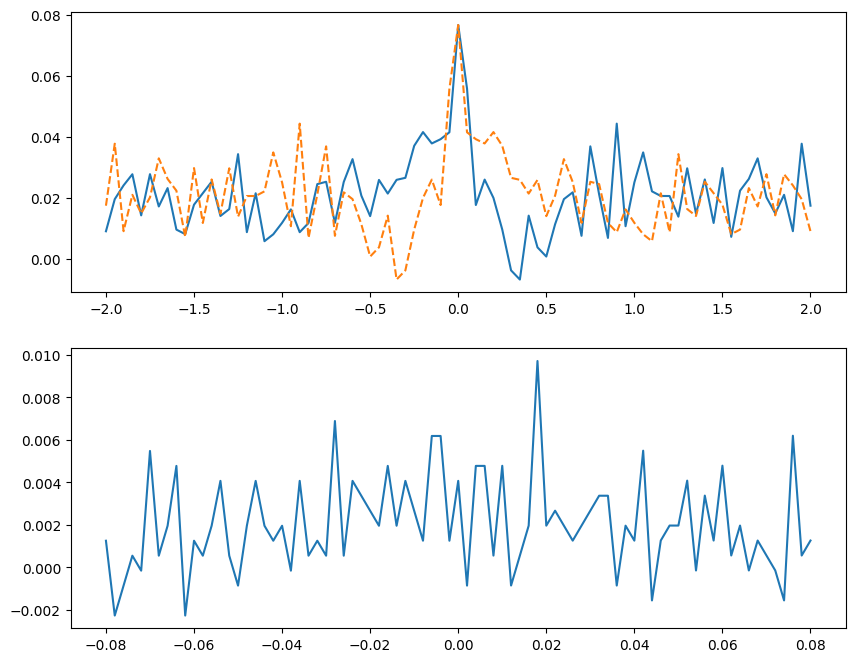

In [10]:
unit_tbl = get_unit_tbl(session, data_type)
unit_ids_focus = unit_tbl[unit_tbl['decoder_label'] != 'artifact']['unit_id'].to_list()

In [9]:
# session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
# session_list = session_assets['session_id']
# probe_list = session_assets['probe']
# probe_list = [probe for probe, session in zip(probe_list, session_list) if isinstance(session, str)]
# session_list = [session for session in session_list if isinstance(session, str)]    
# from joblib import Parallel, delayed
# data_type = 'curated'
# def process(session, data_type): 
#     print(f'Starting {session}')
#     session_dir = session_dirs(session)
#     # if os.path.exists(os.path.join(session_dir['beh_fig_dir'], f'{session}.nwb')):
#     print(session_dir[f'curated_dir_{data_type}'])
#     if session_dir[f'curated_dir_{data_type}'] is not None:
#         try:
#             # plot_ephys_probe(session, data_type=data_type, probe=probe) 
#             cross_auto_corr(session, data_type)
#             plt.close('all')
#             print(f'Finished {session}')
#         except:
#             print(f'Error processing {session}')
#             plt.close('all')
#     else: 
#         print(f'No curated data found for {session}') 
#     # elif session\_dir['curated_dir_raw'] is not None:
#     #     data_type = 'raw' 
#     #     opto_tagging_df_sess = opto_plotting_session(session, data_type, target, resp_thresh=resp_thresh, lat_thresh=lat_thresh, target_unit_ids= None, plot = True, save=True)
# Parallel(n_jobs=-8)(
#     delayed(process)(session, data_type) 
#     for session in session_list
# )

# # process('behavior_754897_2025-03-13_11-20-42', data_type)
# # for session, probe in zip(session_list, probe_list):
# #     process(session, data_type, probe)
# #     plt.close('all')

Starting ecephys_713854_2024-03-05_13-31-20
Starting ecephys_717120_2024-03-06_12-23-53
Starting ecephys_713854_2024-03-05_12-01-40
Starting ecephys_717120_2024-03-07_12-12-02
Starting ecephys_713854_2024-03-08_16-20-33
Starting ecephys_713854_2024-03-08_14-54-25
There are multiple recordings in the curated nwb directory. Picked one with units.
Starting ecephys_717120_2024-03-06_12-54-27
/root/capsule/data/ecephys_713854_2024-03-05_12-01-40_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/ecephys_713854_2024-03-05_13-31-20_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/ecephys_713854_2024-03-08_16-20-33_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/ecephys_717120_2024-03-07_12-12-02_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/ecephys_717120_2024-03-06_12-2

/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 6 and 11
Number of units in LC range: 16
Processing unit 3
Processing units 4 and 5
Processing units 52 and 53


/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 21 and 24
Number of units in LC range: 24
Processing unit 0
Number of units in LC range: 114
Processing unit 5.0
Number of units in LC range: 166
Processing unit 13.0
Number of units in LC range: 124
Processing unit 22.0
Processing units 3 and 4


/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/

Processing units 5.0 and 13.0
Processing units 0 and 3
Processing units 6 and 12
Processing units 52 and 54
Processing units 4 and 6


/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 13.0 and 14.0
Processing units 21 and 26
Processing units 3 and 5


/tmp/ipykernel_11600/3910500316.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 22.0 and 26.0
Processing units 3 and 7
Processing units 52 and 59
Processing units 0 and 4
Processing units 6 and 13
Processing units 4 and 12
Processing units 5.0 and 14.0
Processing units 3 and 10


/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 21 and 27
Processing units 13.0 and 15.0
Processing units 22.0 and 27.0
Skipping units 13.0 and 15.0 due to incompatible drift cuts
Processing units 13.0 and 16.0


/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_11600/3910500316.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Processing units 52 and 62
Processing units 3 and 13
Processing units 6 and 15
Processing units 5.0 and 15.0
Processing units 0 and 9
Processing units 4 and 13
Processing units 21 and 31
Processing units 3 and 14
Processing units 52 and 64
Processing units 6 and 16
Processing units 5.0 and 16.0
Processing units 22.0 and 29.0
Processing units 0 and 10
Processing units 4 and 16
Processing units 3 and 18
Processing units 13.0 and 19.0
Processing units 21 and 32
Processing units 52 and 65
Processing units 6 and 18
Processing units 5.0 and 18.0
Processing units 0 and 11
Processing units 4 and 17
Processing units 3 and 20
Processing units 21 and 33
Processing units 22.0 and 32.0
Processing units 13.0 and 22.0
Processing unit 53
Processing units 6 and 19
Processing units 5.0 and 22.0
Processing units 0 and 12
Processing units 53 and 54
Processing units 4 and 18
Processing units 21 and 35
Processing units 3 and 21
Processing units 13.0 and 24.0
Processing units 5.0 and 23.0
Processing units 22

KeyboardInterrupt: 

['ecephys_713854_2024-03-05_12-01-40',
 'ecephys_713854_2024-03-05_13-01-09',
 'ecephys_713854_2024-03-05_13-31-20',
 'ecephys_717120_2024-03-06_12-23-53',
 'ecephys_717120_2024-03-06_12-54-27',
 'ecephys_717120_2024-03-07_12-12-02',
 'ecephys_713854_2024-03-08_14-54-25',
 'ecephys_713854_2024-03-08_15-43-01',
 'ecephys_713854_2024-03-08_16-20-33',
 'ecephys_713854_2024-03-08_17-15-58',
 'ecephys_684930_2023-09-27_10-04-04',
 'ecephys_684930_2023-09-28_11-45-27',
 'ecephys_684930_2023-09-28_12-44-15',
 'ecephys_687697_2023-09-15_11-30-06',
 'ecephys_687697_2023-09-15_12-36-06',
 'ecephys_691893_2023-10-05_12-46-57',
 'ecephys_691893_2023-10-06_13-48-18',
 'behavior_716325_2024-05-29_10-33-32',
 'behavior_716325_2024-05-30_11-33-46',
 'behavior_716325_2024-05-31_10-31-14',
 'behavior_716325_2024-06-01_09-25-37',
 'behavior_717121_2024-06-11_10-23-31',
 'behavior_717121_2024-06-13_12-21-20',
 'behavior_717121_2024-06-14_10-23-49',
 'behavior_717121_2024-06-15_10-00-58',
 'behavior_717121

In [ ]:
cross_corr_df

,unit_1,unit_2,cross_corr_long,cross_corr_short,start,end
0,10,11,"([0.10200926919638711, 0.04362907474724333, 0....","([0.0036463771130829893, 0.008541877187731667,...",7.165321e+06,7.171568e+06
1,10,12,"([0.07899574598134228, 0.04555429368121589, 0....","([0.009465412686014389, 0.005973386332210205, ...",7.165321e+06,7.171568e+06
2,10,15,"([0.0527512776581984, 0.043061203472371384, 0....","([0.004471735748298048, 0.004735447002790088, ...",7.165321e+06,7.171568e+06
3,10,18,"([0.017524276074430887, -0.011870131140818849,...","([0.005815145606901504, 0.003577636879219868, ...",7.165321e+06,7.171568e+06
4,10,23,"([0.04341201869179076, 0.041732545063786194, 0...","([0.004937083740363691, 0.001273885942614803, ...",7.165321e+06,7.171568e+06
5,10,24,"([0.04589335236936446, 0.03281382579775501, 0....","([0.004746920685482899, 0.0033847179703455055,...",7.165321e+06,7.171568e+06
6,10,25,"([0.11744807261371962, 0.08945177046470547, 0....","([0.007906761137817098, 0.007292462947555057, ...",7.165321e+06,7.171568e+06
